In [13]:
import collections
import math
import os
import random
import zipfile
import numpy as np
import urllib
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
# 下载文本数据的地址
url = 'http://mattmahoney.net/dc/'

In [2]:
# 下载数据的压缩文件并核对文件尺寸，如果已经下载了文件则跳过
def maybe_download(filename, expected_bytes):
    # 如果不存在该文件
    if not os.path.exists(filename):
        # filename: 保存的文件名
        filename, _ = urllib.request.urlretrieve(url + filename, filename)
    # stat 系统调用时用来返回相关文件的系统状态信息
    statinfo = os.stat(filename)
    # 如果下载的文件尺寸与期望的尺寸相同
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:    # 如果尺寸不对
        print(statinfo.st_size)
        # 抛出异常
        raise Exception('Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

In [3]:
filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [4]:
# 解压下载的压缩文件
def read_data(filename):
    with zipfile.ZipFile(filename) as f:
        # 将数据转为单词的列表
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
#         print(f.namelist())
#         print(f.namelist()[0])
    return data

words = read_data(filename)
print('Data Size', len(words))

Data Size 17005207


In [5]:
# 创建vocabulary词汇表
vocabulary_size = 50000

'''
dictionary: 存储了top 5000的单词(字典)，key为单词，value为编号
words: 存储全部的单词
data: 存储top 5000单词的编号，不在top 5000中的单词存储编号为0(列表)
reverse_dictionary: 将dictionary键值对换后的字典
'''
def build_dataset(words):
    count = [['UNK', -1]]
    # Counter: 统计单词列表中单词的频数
    # most_common: 选取top 50000频数的单词作为vocabulary
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))  # 添加到列表count中
    # python中dict的查询复杂度为O(1)
    dictionary = dict()
    for word, _ in count:
        # 按频度存储每个词的编号
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    
    # 遍历单词列表，对每一个单词若出现在dictionary中，则将其转为编号，若不是则转为编号0 
    for word in words:
        # 单词频度在top 50000
        if word in dictionary:
            index = dictionary[word]
        else:  # top 50000以外的单词，我们认定其为Unknow，将其标号为0，并统计其数量
            index = 0
            unk_count += 1
        data.append(index)
        
    count[0][1] = unk_count
    # 词汇表的反转形式
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)

In [6]:
# 删除原始单词列表，以节约内存
del words
print('Most common words (+Unk)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

Most common words (+Unk) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [7]:
data_index = 0


# 生成训练用的batch数据
def generate_batch(batch_size, num_skips, skip_window):
    '''
    batch_size: batch的大小
    num_skips: 对每个单词可生成的样本 <= skip_window * 2, 且必须能被batch_size整除
    skip_window: 指单词最远可以联系的距离
    '''
    # 定义为全局变量，因为我们要确保data_index可在函数内部进行修改
    global data_index
    # 断言函数，保证我们的要求满足
    assert batch_size  % num_skips == 0
    assert num_skips <= 2 * skip_window
    # 将batch和labels初始化为数组
    batch = np.ndarray(shape = (batch_size), dtype = np.int32)
    labels = np.ndarray(shape = (batch_size, 1), dtype = np.int32)
    # span: 为某个单词创建相关样本时所需要的单词数量（1是单词其本身）
    span = 2 * skip_window + 1
    # 创建一个最大容量为span的双端队列
    buffer = collections.deque(maxlen = span)
    
    # 从序号data_index开始，把span个单词顺序读入buffer作为初始值
    for _ in range(span): 
        buffer.append(data[data_index])   # buffer中存储的是单词的编号
        data_index = (data_index + 1) % len(data)
    # 每次循环对一个目标单词生成样本
    for i in range(batch_size // num_skips):    
        target = skip_window  # 表示buffer中第skip_window个变量为目标单词
        targets_to_avoid = [skip_window]  # 生成样本是要避免出现的单词
        
        for j in range(num_skips):
            while rnd in targets_to_avoid:
                target = random.randint(0, span-1)   # 产生随机数，直到随机数不在target_to_avoid中
            targets_to_avoid.append(target)
            # batch和labels存储的都是单词的编号
            batch[i * num_skips + j] = buffer[skip_window]  # 对应的目标，即context对应的单词
            labels[i * num_skips + j, 0] = buffer[target]  # 自己的标签，即target对应的单词
        
        buffer.append(data[data_index])  # buffer中第一个单词会因为append后一个单词而出队
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [8]:
batch, labels = generate_batch(batch_size = 8, num_skips = 2, skip_window = 1)
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]], '->', labels[i, 0], 
        reverse_dictionary[labels[i, 0]])
# ['anarchism', 'originated', 'as', 'a', 'term', 'of',...]

3081 originated -> 12 as
3081 originated -> 5234 anarchism
12 as -> 6 a
12 as -> 3081 originated
6 a -> 195 term
6 a -> 12 as
195 term -> 6 a
195 term -> 2 of


In [9]:
batch_size = 128  
embedding_size = 128  # 单词转为稠密向量的维度
skip_window = 1 # 前后最远可以联系的距离
num_skip = 2  # 对每个目标单词提取的样本数

'''
生成验证数据valid_examples，这里随机抽取一些频数最高的单词
看向量空间上跟它们最近的单词是否相关性比较高
'''
valid_size = 16  # 抽取的验证单词数
valid_window = 100  # 从验证单词中只取频数最高的前100个单词
valid_examples = np.random.choice(valid_window, valid_size, replace = True)  # replace=True表示抽样后放回
num_sample = 64  # 训练时用来做负样本的噪声单词数量

In [46]:
# 定义Skip-Gram Word2Vec模型的网络结构
graph = tf.Graph()
with graph.as_default():
    train_inputs = tf.placeholder(tf.int32, shape = [batch_size])
    train_labels = tf.placeholder(tf.int32, shape = [batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype = tf.int32)
    
    # 随机生成词向量50000x128
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    # 查找输入train_inputs对应的向量embed
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], 
                                                 stddev = 1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
    # 用NCE Loss作为训练的优化目标    
    loss = tf.reduce_mean(tf.nn.nce_loss(weights = nce_weights,
                                         biases = nce_biases,
                                         labels = train_labels,
                                         inputs = embed,
                                         num_sampled = num_sample,
                                         num_classes = vocabulary_size))
    # 优化方法
    optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)
    # 计算embeddings的模
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims = True))
    # 相当于向量 / 模，做单位化
    normalized_embedding = embeddings / norm
    
    valid_embeddings = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    # 计算余弦相似度(因为除了个norm，所以下面其实就是"向量内积/模模")
    similarity = tf.matmul(valid_embeddings, normalized_embedding, transpose_b = True)
    
    init = tf.global_variables_initializer()
    num_steps = 100001
    
    with tf.Session() as sess:
        sess.run(init)
        average_loss = 0
        for step in range(num_steps):
            batch_inputs, batch_labels = generate_batch(batch_size, num_skip, skip_window)
            feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
            
            # 进行训练
            _, loss_val = sess.run([optimizer, loss], feed_dict = feed_dict)
            average_loss += loss_val
            
            # 每2000轮计算一次损失结果
            if step % 2000 == 0:
                if step >= 0:
                    average_loss /= 2000
                print("Average loss at step ", step, ": ", average_loss)
                average_loss = 0
            
            # 每10000次验证一次验证单词与全部单词的相似度，并将每个验证单词最相似的8个单词展示出来
            if step % 10000 == 0:
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = reverse_dictionary[valid_examples[i]]
                    top_k = 8
                    # 找出相似度最高的top_k个单词
                    nearest = (-sim[i, :]).argsort()[1: top_k+1]
                    log_str = "Nearest to %s :" % valid_word
                    for k in range(top_k):
                        close_word = reverse_dictionary[nearest[k]]
                        log_str = "%s %s, " % (log_str, close_word)
                    print(log_str)
            final_embeddings = normalized_embedding.eval()

Average loss at step  0 :  0.15435678100585937
Nearest to after : db,  cordilleras,  musculoskeletal,  dauphin,  concerted,  clamps,  bangla,  sought, 
Nearest to he : tyrell,  dalit,  loony,  disquieting,  moratorium,  uni,  ap,  scattering, 
Nearest to there : altitudes,  slashed,  cornwell,  kosrae,  emergencies,  prejudicial,  knuckles,  ugle, 
Nearest to called : malicious,  romero,  electrical,  thinkpad,  saville,  sent,  paula,  degraded, 
Nearest to d : esr,  distribution,  replaced,  yokoi,  agitating,  jill,  wingspan,  nicol, 
Nearest to first : quadriceps,  perlite,  scarab,  rung,  warbler,  plh,  seriously,  escaping, 
Nearest to may : ndez,  paulette,  ruthenia,  stuart,  halts,  doom,  opportunistic,  feces, 
Nearest to see : artifice,  hit,  ballroom,  floyd,  jock,  hardness,  sequels,  employs, 
Nearest to in : nt,  outcome,  strongly,  replacements,  hydroxides,  nadezhda,  irritant,  disturbances, 
Nearest to can : chromatids,  ecology,  bonfires,  seebeck,  fairw

Average loss at step  52000 :  12.695223282337189
Average loss at step  54000 :  11.89168154811859
Average loss at step  56000 :  11.789895660758019
Average loss at step  58000 :  10.10579814171791
Average loss at step  60000 :  10.341001080036163
Nearest to after : before,  and,  however,  nine,  run,  period,  last,  seven, 
Nearest to he : it,  she,  they,  who,  never,  soon,  there,  subsequently, 
Nearest to there : they,  still,  it,  currently,  generally,  usually,  now,  actually, 
Nearest to called : or,  and,  sent,  considered,  suggested,  replaced,  true,  confirmed, 
Nearest to d : p,  b,  c,  UNK,  l,  m,  g,  j, 
Nearest to first : last,  next,  return,  second,  past,  following,  under,  southeast, 
Nearest to may : can,  would,  should,  could,  will,  might,  cannot,  won, 
Nearest to see : managed,  and,  refer,  featuring,  hit,  mean,  saw,  succeeded, 
Nearest to in : and,  late,  throughout,  within,  at,  during,  under,  nine, 
Nearest to can : could,  woul

In [52]:
# 定义可视化Word2Vec效果的函数
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(10, 10))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)   # 绘制散点图
        # 对点进行说明
        plt.annotate(label,  # 注释的文本内容
                     xy=(x, y),   # xy表示注释的坐标点
                     xytext=(5, 2),  # 注释文本相对于点的坐标
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    plt.savefig(filename)

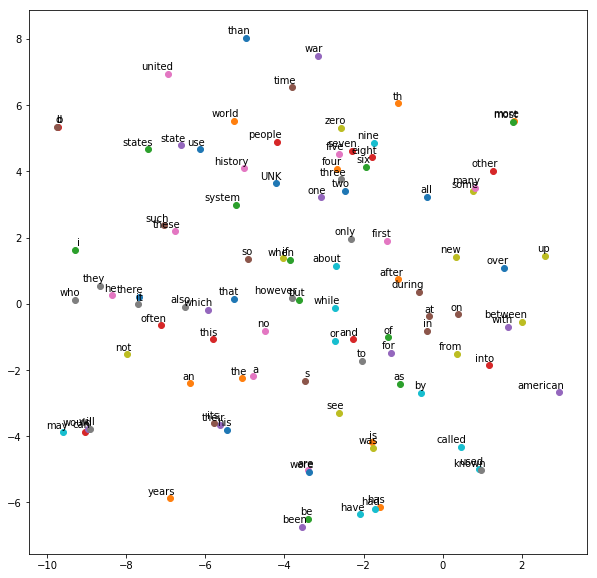

In [53]:
# 使用T-SNE算法将128维的嵌入向量降到2维
tsne = TSNE(perplexity = 30, n_components = 2, init = 'pca', n_iter = 5000, random_state = 1)
# 绘制点的个数
plot_only = 100
low_dim_embs = tsne.fit_transform(final_embeddings[: plot_only, :])
labels = [reverse_dictionary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

array([[ 0.10847012,  0.10653093,  0.00670613, ...,  0.067011  ,
         0.14987001, -0.03424044],
       [ 0.08443932,  0.02620201, -0.09507011, ...,  0.10157181,
         0.05338756,  0.0159486 ],
       [ 0.00071717,  0.07805133, -0.08965474, ...,  0.05293749,
         0.16476966, -0.0483076 ],
       ...,
       [ 0.07252762, -0.0169244 ,  0.04000595, ...,  0.04296862,
         0.04794205, -0.11309797],
       [ 0.02829984,  0.08615713, -0.12374687, ...,  0.08210798,
         0.2868501 , -0.12711978],
       [ 0.00992854,  0.00623027, -0.12442369, ...,  0.03110308,
         0.28380895, -0.06318813]], dtype=float32)